## Machine Learning on Titanic passengers survival data

This Notebook will use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The dataset provides information on the fate of passengers on the Titanic, summarized according to economic status (class), sex, age and survival.

Credit for this Notebook goes to Niklas Donges, who published a very detailed post [here](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8). Check it out if you want to dive deeper in the data analysis and machine learning details of the challenge.

#### Import dependencies and load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz

import pickle
import pydot

In [2]:
path = "data/"

PREDICTION_LABEL = 'Survived'

test_df = pd.read_csv(path + "test.csv")
train_df = pd.read_csv(path + "train.csv")

#### Let's explore the data

These are features of the dataset:
```
survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation
```

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Pclass             891 non-null int64
Sex                891 non-null int64
Age                891 non-null int64
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null int64
Embarked           891 non-null int64
relatives          891 non-null int64
not_alone          891 non-null int64
Deck               891 non-null int64
Title              891 non-null int64
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(13)
memory usage: 90.6 KB


In [40]:
train_df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,3.474747,0.523008,0.381594,1.523008,0.361392,0.904602,0.602694,6.936027,1.728395,7.585859,0.801347
std,0.836071,0.477990,1.861551,1.102743,0.806057,1.250743,0.635673,1.613459,0.489615,2.074282,1.030039,4.832263,0.953903
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,4.000000,0.000000
50%,3.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,6.000000,1.000000
75%,3.000000,1.000000,5.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,8.000000,2.000000,12.000000,1.000000
max,3.000000,1.000000,6.000000,8.000000,6.000000,5.000000,2.000000,10.000000,1.000000,8.000000,5.000000,18.000000,5.000000


In [41]:
train_df.head(8)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,5,1,0,3,1,1,0,3,3,5,1
2,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,5,1,0,3,0,1,0,3,3,5,1
4,3,0,5,0,0,1,0,0,1,8,1,15,1
5,3,0,1,0,0,1,2,0,1,8,1,3,1
6,1,0,6,0,0,3,0,0,1,5,1,6,3
7,3,0,0,3,1,2,0,4,0,8,4,0,0


**Missing data**

Let's see here how much data is missing. We will have to fill the missing features later on.

In [42]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Fare_Per_Person,0,0.0
Age_Class,0,0.0
Title,0,0.0
Deck,0,0.0
not_alone,0,0.0


**Age and Sex**

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


KeyError: 'Survived'

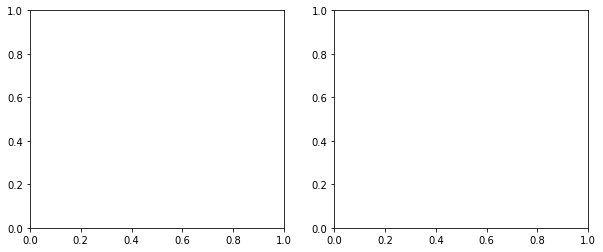

In [43]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax.set_ylabel('Survival Probablity')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')
_ = ax.set_ylabel('Survival Probablity')

**Embarked, Pclass and Sex**

In [ ]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
_ = FacetGrid.add_legend()

**Pclass**

Explore if `Pclass` is contributing to a person chance of survival 

In [ ]:
_ = sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we confirm that being in class 1 increases the chances of survival, and that a person in class 3 has high chances of not surviving

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## DATA PROCESSING

#### SibSp and Parch

Combine these two features as the number of relatives

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

In [ ]:
# Survival with respect to the number of relatives in the ship
axes = sns.catplot('relatives','Survived', kind='point',
                      data=train_df, aspect = 2.5, )

In [ ]:
# This does not contribute to a person survival probability
train_df = train_df.drop(['PassengerId'], axis=1)

#### Missing data: Cabin

Create a new `Deck` feature

In [ ]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Missing data: Age

Fill missing data from age feature with a random sampling from the distribution of the existing values.

In [ ]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

#### Missing data: Embarked

In [ ]:
train_df['Embarked'].describe()

In [ ]:
# fill with most common value
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

#### Convert Features

In [ ]:
train_df.info()

In [ ]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Titles features

In [ ]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### Sex into numeric

In [ ]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Drop Ticket feature

In [ ]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### Embarked into numeric

In [ ]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### Age into categories

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

#### Fare into categories

In [ ]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## New Features

#### Age times Class

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per person

In [ ]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

## ML

Because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other

In [ ]:
train_labels = train_df[PREDICTION_LABEL]
train_df = train_df.drop(PREDICTION_LABEL, axis=1)



#### Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_df, train_labels)
acc_random_forest = round(random_forest.score(train_df, train_labels) * 100, 2)

#### Logistic Regression

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=110)
logreg.fit(train_df, train_labels)
acc_log = round(logreg.score(train_df, train_labels) * 100, 2)

#### Gaussian Naive Bayes

In [ ]:
gaussian = GaussianNB()
gaussian.fit(train_df, train_labels)
acc_gaussian = round(gaussian.score(train_df, train_labels) * 100, 2)

#### SVM

In [ ]:
linear_svc = SVC(gamma='auto')
linear_svc.fit(train_df, train_labels)
acc_linear_svc = round(linear_svc.score(train_df, train_labels) * 100, 2)

#### Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_df, train_labels)
acc_decision_tree = round(decision_tree.score(train_df, train_labels) * 100, 2)

In [ ]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'logistic Regression',
              'Random Forest', 'Naive Bayes', 'Decision Tree'],
    'Score': [acc_linear_svc, acc_log,
              acc_random_forest, acc_gaussian, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
print(result_df)

In [63]:
model_score = 0
model_name = "test"
for index, row in results.iterrows():
    if row['Score'] > model_score:
        model_score = row['Score']
        model_name = row['Model']
    print(row['Score'], row['Model'])
print(model_name)

c = pd.DataFrame({
    'Model': [linear_svc, logreg, random_forest, gaussian, decision_tree],
    'RealModel' : ['Support Vector Machines', 'logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
})

model_to_deploy = None
for index, row in c.iterrows():
    if model_name == row['RealModel']:
        model_to_deploy = row['Model']

#print(model_to_deploy)

with open('../deployment/web/model/trained_model.pickle', 'wb') as f:
    pickle.dump(model_to_deploy, f)

model_tree = model_to_deploy.estimators_[5]

export_graphviz(model_tree, out_file = '../deployment/web/model/model_tree.dot', feature_names = train_df.columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('../deployment/web/model/model_tree.png')


86.31 Support Vector Machines
81.37 logistic Regression
92.93 Random Forest
77.78 Naive Bayes
92.93 Decision Tree
Random Forest


In [64]:
import paramiko

In [67]:
host = ""
port = 23
username = ""
password = ""

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host, port, username, password)

ftp_client=ssh.open_sftp()
ftp_client.put('source_path_model',
               'destination_path_model')
ftp_client.put('source_path_image',
              'destination_path_image')
ftp_client.close()

In [38]:
command = "cd /home/mkroneder/Documents/kubeflow-example/deployment; ./start"

# execute the BASH script
stdin, stdout, stderr = ssh.exec_command(command)
# read the standard output and print it
print(stdout.read().decode())
# print errors if there are any
err = stderr.read().decode()
if err:
    print(err)
# close the connection
ssh.close()

74a7c6c187c2f7b775ea398708699a5e07c86a30a017047d23fc8e567fb84338

